# Stat project 4


## Задание
Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.


## Описание данных
- order_id - id заказа
- delivery_time - время доставки в минутах
- district - район доставки
- experiment_group - экспериментальная группа

## Гипотезы

1. Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет
2. Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import pingouin as pg
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy
from scipy import stats

In [2]:
sns.set(rc={'figure.figsize': (12, 6)}, style="whitegrid")

In [3]:
# таблица с уникальными идентификаторами пользователей
df = pd.read_csv('./experiment_lesson_4.csv')

In [4]:
df.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [5]:
df.district.unique()

array(['Purlieus', 'Central', 'Suburb'], dtype=object)

In [6]:
df.experiment_group.unique()

array(['control', 'test'], dtype=object)

# Задание 1
Сопоставьте графики распределения и  экспериментальные группы (нужны гистограммы)

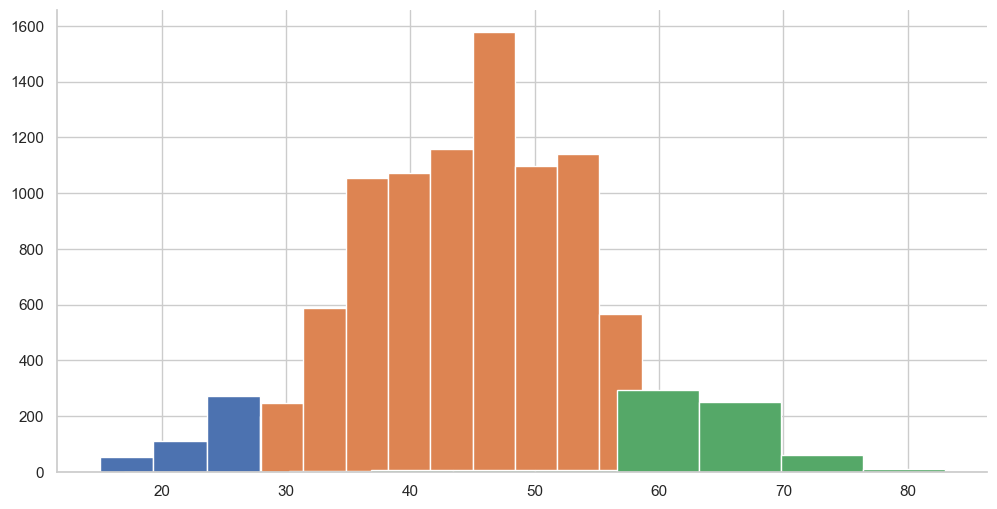

In [7]:
df.query("experiment_group == 'control'").groupby('district').delivery_time.hist()
sns.despine()

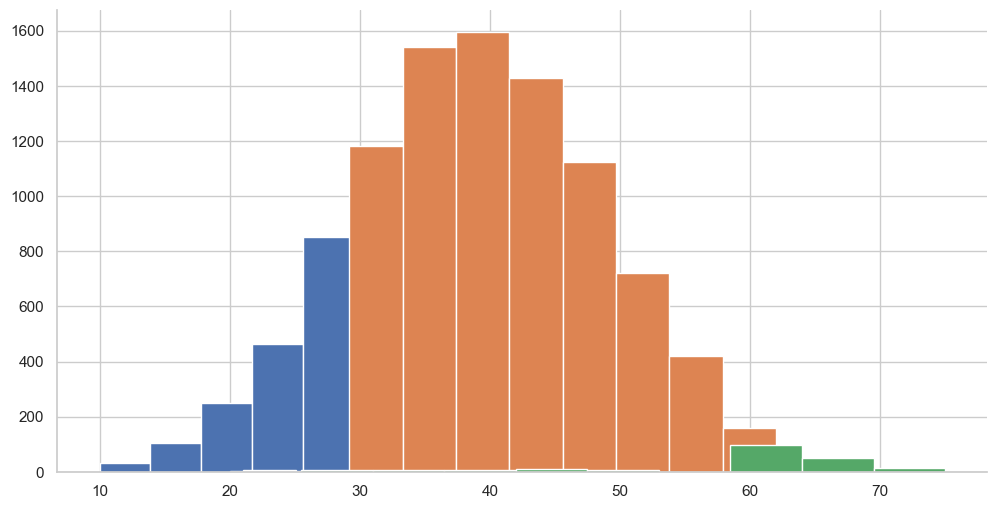

In [8]:
df.query("experiment_group == 'test'").groupby('district').delivery_time.hist()
sns.despine()

# Задание 2
Посчитайте количество наблюдений в тестовой и контрольной группе. 
На сколько по модулю отличается количество наблюдений в тесте и контроле?

In [9]:
#test
df.query("experiment_group == 'test'").value_counts().sum()

10104

In [10]:
#control
df.query("experiment_group == 'control'").value_counts().sum()

10092

**Ответ:** 12

In [11]:
#or
df.groupby('experiment_group').size()

experiment_group
control    10092
test       10104
dtype: int64

# Задание 3
Теперь давайте изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.

Вообще для выборок таких колоссальных размеров мы не обязаны это делать - в отсутствие слишком уж выраженной асимметрии и выбросов в данных t-тест и так работать будет нормально, но посмотреть лишний раз всё равно можно :)

Обычно нормальность тестируют с помощью теста Шапиро-Уилка (scipy.stats.shapiro()), однако на больших выборках этот тест слишком рьяно находит отклонения от нормальности! Поэтому используйте функцию scipy.stats.normaltest() - она больше адаптирована к большим выборкам.

Также можете сделать это через пакет pingouin - вот этой функцией. Не забудьте выбрать правильный аргумент!

In [12]:
scipy.stats.shapiro(df[df['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17))

ShapiroResult(statistic=0.9975473880767822, pvalue=0.14001426100730896)

In [13]:
scipy.stats.shapiro(df[df['experiment_group'] == 'control']['delivery_time'].sample(1000, random_state=17))

ShapiroResult(statistic=0.9974724054336548, pvalue=0.12408281117677689)

In [14]:
#второй вариант(!)

In [15]:
pg.normality(data=df, dv='delivery_time', group='experiment_group', method='normaltest')

,W,pval,normal
experiment_group,,,
control,0.253498,0.880955,True
test,7.024157,0.029835,False


<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

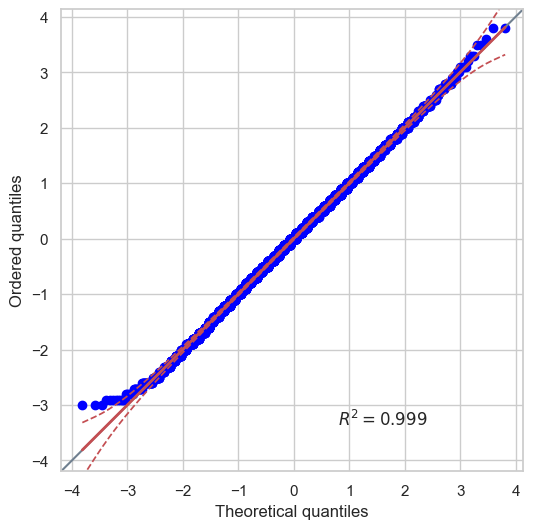

In [16]:
pg.qqplot(df.query("experiment_group == 'control'").delivery_time)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

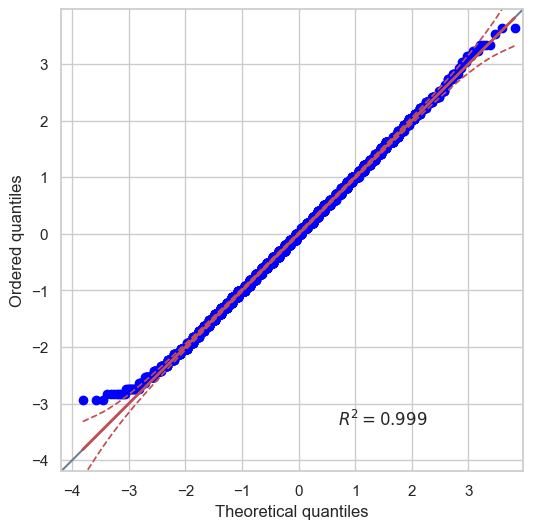

In [17]:
pg.qqplot(df.query("experiment_group == 'test'").delivery_time)

Для того, чтобы проверить нормальность распределения, я использую тест Агостино-Пирсона по функции scipy.stats.normaltest(). Этот тест показывает, что значения в тестовой группе распределены **ненормально**. В контрольной группе распределение является **нормальным**. Стандартное отклонение времени доставки в тесте равно (округлите до сотых) 
**9.88**. Стандартное отклонение времени доставки в контроле равно (округлите до сотых) **9.99**.


**Note**
В прошлых версиях этого курса мы полагались на другой трюк - сэмплирование данных из каждой группы, чтобы обойти проблемы чувствительности теста. Метод не очень надёжный, поэтому мы от него в итоге отказались, но можете его попробовать по методу ниже! Впрочем, не интерпретируйте его результаты слишком серьёзно

In [18]:
np.round(df.query("experiment_group == 'test'").delivery_time.std(), 2)

9.88

In [19]:
np.round(df.query("experiment_group == 'control'").delivery_time.std(), 2)

9.99

# Задание 4
Теперь пришло время сравнить средние в тесте и контроле. 

In [20]:
scipy.stats.ttest_ind(df.query("experiment_group == 'test'").delivery_time, 
                      df.query("experiment_group == 'control'").delivery_time )

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

In [21]:
#тест и контроль различаются

In [22]:
#второй вариант
pg.ttest(x=df.query("experiment_group == 'test'").delivery_time,
         y=df.query("experiment_group == 'control'").delivery_time)

c:\Users\Ann Zalivatskaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\pingouin\bayesian.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-43.035552,20191.127788,two-sided,0.0,"[-6.29, -5.74]",0.605658,inf,1.0


**Вывод**
Для сравнения средних в данных экспериментальных группах я использую **Student's T-test**. Статистика в тесте равна (округлите до целого) **-43**, p-value **<= 0.05**.

# Задание 5
На сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной (округлите до сотых)? 

In [23]:
mean_test = df.query("experiment_group == 'test'").delivery_time.mean()

In [24]:
mean_control = df.query("experiment_group == 'control'").delivery_time.mean()

In [25]:
np.round((1 - (mean_test/mean_control))*100, 2)

13.35

# Вывод
Что в итоге? Катим? 

Да, раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. 
Среднее время доставки в тесте меньше, чем в контроле.